# Importing Plotting Functions

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  

# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
correlations_survey = correlations[survey_fields]

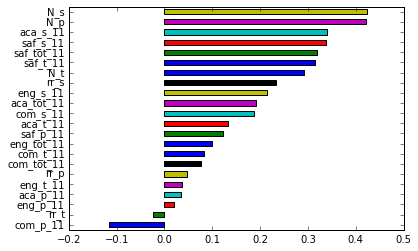

In [19]:
correlations_survey.sort_values().plot.barh()

Notably, the fields that have a correlation that should be further investigated (in descending order of r value, only above 0.25 shown) are:
* N_s: Number of student respondents
* N_p: Number of parent respondents
* aca_s_11: Academic expectations score based on student responses
* saf_s_10: Safety and Respect score based on student responses
* saf_t_10: Safety and Respect total score
* N_t: Number of teacher respondents

It is interesting to note that a lot of these values are around teacher/student engagement, as each of these are positively correlated with SAT Scores, this suggests that there may be a link between engagement between students, parents and teachers.

It is interesting that teacher engagement with these surveys may have an impact on the students' SAT scores.

It can also be observed that two columns around safety and respect (saf_s_10 and saf_t_10) correlate positively with the SAT scores. We will further investigate these values.

# Exploring Safety and SAT Scores

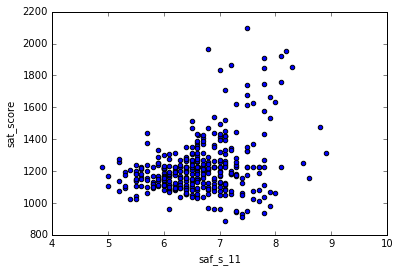

In [21]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

The above plot shows us the weak but positive correlation between safety perceptions and SAT scores. This may be largely affected by a cluster of values in the lower left portion of the plot.

## Mapping Safety Scores by District

In [27]:
dist_averages = combined.groupby('school_dist').agg(numpy.mean, axis=0)

In [33]:
dist_averages.head(5)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,NaN,NaN,NaN,441.833333,473.333333,439.333333,1354.500000,NaN,116.681090,173.019231,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,40.719022,-73.982377
02,NaN,NaN,NaN,426.619092,444.186256,424.832836,1295.638184,NaN,128.908454,201.516827,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,40.739699,-73.991386
03,NaN,NaN,NaN,428.529851,437.997512,426.915672,1293.443035,NaN,156.183494,244.522436,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,40.781574,-73.977370
04,NaN,NaN,NaN,402.142857,416.285714,405.714286,1224.142857,NaN,129.016484,183.879121,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,40.793449,-73.943215
05,NaN,NaN,NaN,427.159915,438.236674,419.666098,1285.062687,NaN,85.722527,115.725275,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,40.817077,-73.949251


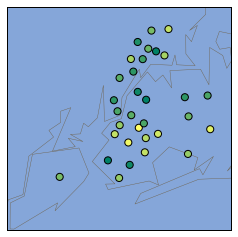

In [67]:
from mpl_toolkits.basemap import Basemap
m = Basemap( projection='merc', 
            llcrnrlat=40.496044, 
            urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, 
            urcrnrlon=-73.700272, 
            resolution='i' ) 
m.drawmapboundary(fill_color='#85A6D9') 
m.drawcoastlines(color='#6D5F47', linewidth=.4) 
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes = dist_averages["lon"].tolist()
latitudes = dist_averages["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=c_vals, cmap='summer_r')

In [68]:
dist_averages_normalised = dist_averages['saf_s_11'] / dist_averages['saf_s_11'].max()

In [61]:
c_vals = dist_averages_normalised.apply(numpy.round, decimals=2)

In [62]:
print(type(c_vals))

<class 'pandas.core.series.Series'>
